# Обработка данных 

Считывание данных из файла .gpx:

In [1]:
import gpxpy


with open('strava.activities.2778810805.gpx') as f: 
    gpx = f.read()

gpx_track = gpxpy.parse(gpx)

Преобразование данных в датафрейм pandas со столбцами:
<br>latitude - широта
<br>longitude - долгота
<br>elevation - высота над уровнем моря
<br>timestamp - дата
<br>В итоге получим датафрейм coords в котором каждая строка соответствует определенной точке на карте в определённый момент времени

In [2]:
import pandas as pd
coords = pd.DataFrame(columns=['latitude', 'longitude', 'elevation', 'timestamp'])
for track in gpx_track.tracks:
    for segment in track.segments:
        for point in segment.points:
            coord = pd.DataFrame([[point.latitude, point.longitude, point.elevation, point.time]], 
                                 columns=['latitude', 'longitude', 'elevation', 'timestamp'])
            coords = coords.append(coord, ignore_index=True)
            
coords.head()

,latitude,longitude,elevation,timestamp
0,55.716209,37.552902,163.5,2019-10-10 09:00:00+00:00
1,55.716021,37.552955,163.9,2019-10-10 09:00:04+00:00
2,55.715826,37.552931,161.7,2019-10-10 09:00:07+00:00
3,55.715799,37.552849,162.0,2019-10-10 09:00:09+00:00
4,55.715753,37.553462,156.0,2019-10-10 09:01:12+00:00


Расчёт расстояния для соседних точек:

In [3]:
from geopy import distance

dist = pd.Series(dtype=float)
for i in range(1, coords.shape[0]):
    delta_elevation = coords['elevation'][i] - coords['elevation'][i - 1]
    delta_horizontal = distance.distance((coords['latitude'][i], coords['longitude'][i]),
                                    (coords['latitude'][i - 1], coords['longitude'][i - 1])).m
    delta_dist = (delta_elevation ** 2 + delta_horizontal ** 2) ** 0.5
    dist = dist.append(pd.Series(delta_dist), 
                       ignore_index=True)
dist.index += 1
print(dist.head())


1    21.198458
2    21.873899
3     5.973865
4    39.326303
5     4.268336
dtype: float64


Расчёт времение (в секундах) для каждой пары соседних точек:

In [4]:
deltat = coords['timestamp'].apply(lambda x: x.timestamp()).diff()[1:] 
print(deltat.head())


1     4.0
2     3.0
3     2.0
4    63.0
5     2.0
Name: timestamp, dtype: float64


Расчёт темпа (минуты/километры) на каждом из отрезков времени:

In [5]:
pace =  (deltat / dist) * 1000 / 60
pace = pd.concat([pd.Series([None], index=[0]), pace])
print(pace.head())


0       None
1    3.14488
2    2.28583
3    5.57986
4    26.6997
dtype: object


Расчёт ряда накопленных расстояний с начала поездки

In [6]:
cumdist = dist.cumsum()
cumdist = pd.concat([pd.Series([0], index=[0]), cumdist])
print(cumdist.head())

0     0.000000
1    21.198458
2    43.072358
3    49.046222
4    88.372526
dtype: float64


# Визуализация данных о поездке

Построение графиков высоты над уровнем моря (coords.elevation) и темпа прогулки (pace) как функции накопленного расстояния (cumdist):

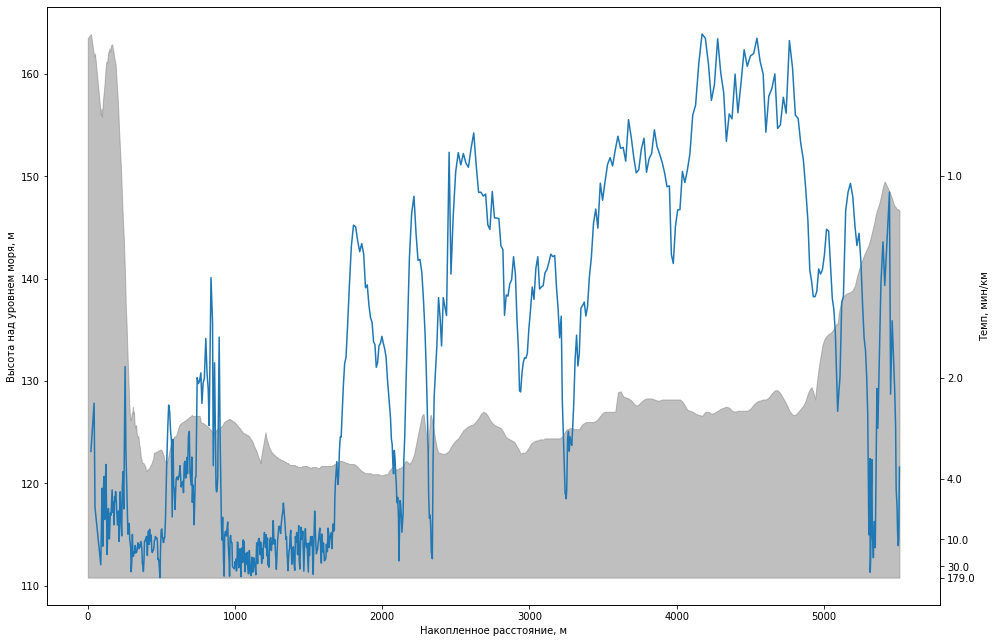

In [8]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(16, 11))
ax2 = ax1.twinx()

ax1.fill_between(cumdist, coords.elevation, coords.elevation.min()-10, color='grey', alpha=0.5)
ax2.plot(cumdist, 1/pace)
labels = np.array([1, 2, 4, 10, 30, 179])
locs = 1/labels
ax2.set_yticks(locs)
ax2.set_yticklabels(1/locs)
ax1.set(xlabel='Накопленное расстояние, м', ylabel='Высота над уровнем моря, м')
ax2.set(ylabel='Темп, мин/км')
plt.show()

Как видно из графика выше, данные по темпу получились довольно шумные (резко колеблются). Для того, чтобы сгладить шумы, применем скользящее среднее:

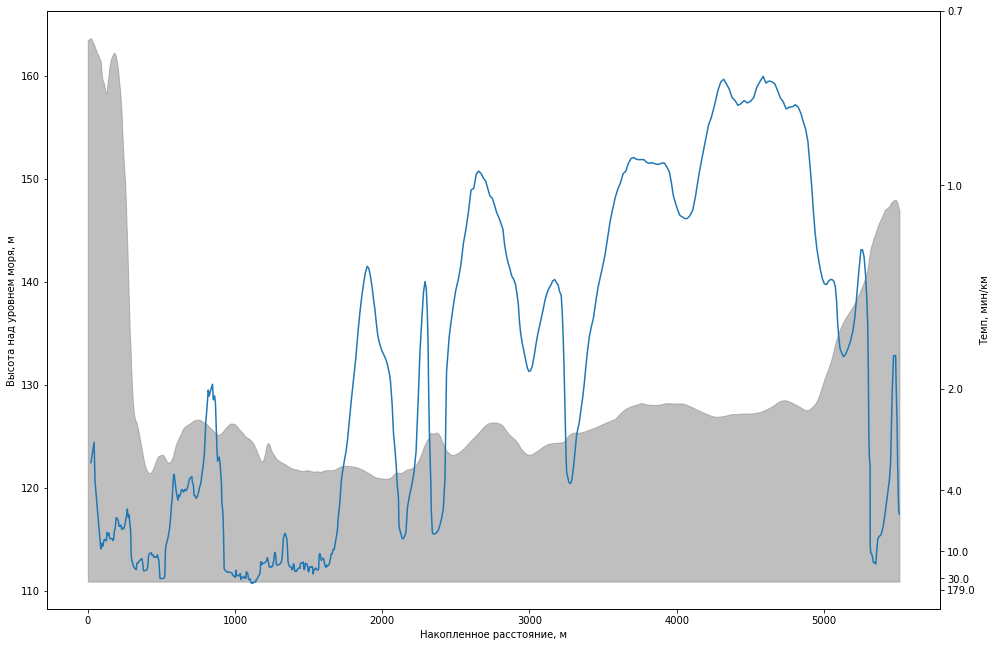

In [9]:
pace2 = pace.rolling(10,min_periods=1).mean()
elevation2 = coords.elevation.rolling(10,min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(16, 11))
ax2 = ax1.twinx()

ax1.fill_between(cumdist, elevation2, elevation2.min()-10, color='grey', alpha=0.5)
ax2.plot(cumdist, 1/pace2)
labels = np.array([0.7, 1, 2, 4, 10, 30, 179])
locs = 1/labels
ax2.set_yticks(locs)
ax2.set_yticklabels(1/locs)
ax1.set(xlabel='Накопленное расстояние, м', ylabel='Высота над уровнем моря, м')
ax2.set(ylabel='Темп, мин/км')
plt.show()


Визуализация поездки на карте. Тёплые цвета соответствуют большей скорости, холодные цвета, соответственно, меньшей.

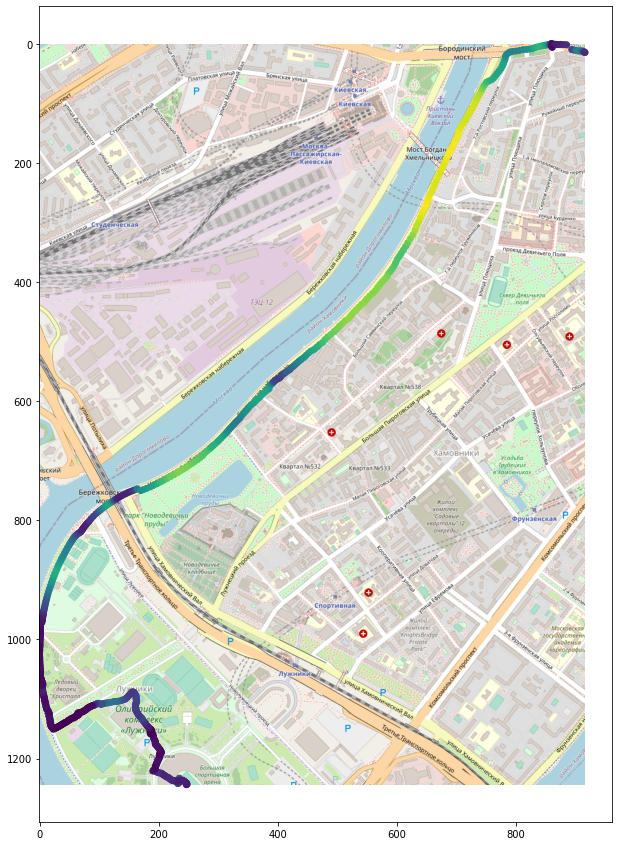

In [13]:
import geotiler
import nest_asyncio
from matplotlib.collections import LineCollection

nest_asyncio.apply()
mmap = geotiler.Map(extent=(min(coords.longitude),
                            min(coords.latitude),
                            max(coords.longitude),
                            max(coords.latitude)), 
                    zoom=15)

x, y = zip(*(mmap.rev_geocode(c) for c in zip(coords.longitude, coords.latitude)))

img = geotiler.render_map(mmap)


segs = []
for i in range(1, len(x)):
    segs.append([[x[i-1], y[i-1]], [x[i], y[i]]])


colors = (100*(pace2[1:].min()/pace2[1:])*(pace2[1:].max() - pace2[1:])/(pace2[1:].max()-pace2[1:].min())).astype(int)
lc = LineCollection(segs, linewidth=10)

fig = plt.figure(figsize=(15, 15))
ax_img = plt.subplot(111)
ax_img.scatter(x[1:], y[1:], c=colors)
ax_img.imshow(img)


# Вывод

Как видно из графиков (высоты над уровнем моря и темпа прогулки как функции накопленного расстояния) темп поездки меняется довольно скачкообразно. При этом видим, что ни высота над уровнем моря, ни накопленное расстояние прямой взаимосвязи с темпом не имеют. Резкие изменения темпа можно объяснить условием городского движения (светофоры, пешеходные переходы, загруженность дорог, необходимость сделать манёвр). Также из визуализации поездки на карте можно увидеть, что наибольший темп был набран на длинном и прямом участке дороги. 